In [395]:
import pandas
import numpy as np

Load the poll data file:

In [396]:
POLLS_FILE = "PMbPp.csv"

data = pandas.read_csv(POLLS_FILE)
STATE = data["Contest"][0]

Convert the sample count to an integer: 

In [397]:
data["SampleInteger"] = data["Sample"].apply(lambda x: int(x.split("@@")[1]))

Find the absolute (i.e. no +/-) margins *just* among the major candidates; ignore undecided and 3rd party respondents

In [398]:
margins = (data["Harris"] - data["Trump"]) / (data["Harris"] + data["Trump"])
data["AbsoluteMargin"] = np.absolute(margins)
data["AbsoluteMargin"]

0     0.026455
1     0.020408
2     0.005236
3     0.005661
4     0.011765
        ...   
95    0.005405
96    0.005348
97    0.043478
98    0.047120
99    0.021277
Name: AbsoluteMargin, Length: 100, dtype: float64

Use the Trump and Harris percentages to infer the total number of respondents who only responded either "Trump" or "Harris":

In [399]:
# The total number of poll respondents in each poll who said they planned to vote for either Harris or Trump:
# np.ceil rounds up; this would decrease variance and is therefore being generous to the pollsters
data["HarrisOrTrumpTotal"] = np.ceil(data["SampleInteger"] * ((data["Harris"] + data["Trump"]) / 100)).astype(int)
data["HarrisOrTrumpTotal"]

0     1234
1     1304
2      794
3     1429
4      712
      ... 
95     648
96    1028
97     432
98     705
99     376
Name: HarrisOrTrumpTotal, Length: 100, dtype: int64

Calculate the observed mean absolute margin, i.e. the average percent difference between each of the candidates' respondent shares

In [400]:
mean_observed_absolute_margin = data["AbsoluteMargin"].mean()
print(f"Observed mean absolute margin across all polls in {STATE}: {100 * mean_observed_absolute_margin:.2f}%")

Observed mean absolute margin across all polls in Wisconsin: 2.03%


This function simulates a poll and then tells you the percent margin (not actually percent; it's on a 0.0 - 1.0 scale) of respondents who favor one candidate over another.

In [401]:
def simulate_poll(n: int, harris_share: float = 0.5) -> float:
    """Simulate poll of `n` planned Harris/Trump voters; return the absolute margin;
    `probability` is the share of all voters who plan to vote for Harris"""
    responses = np.random.random(n) > harris_share
    margin = (responses.mean() - 0.5) * 2
    absolute_margin = np.abs(margin)
    return absolute_margin

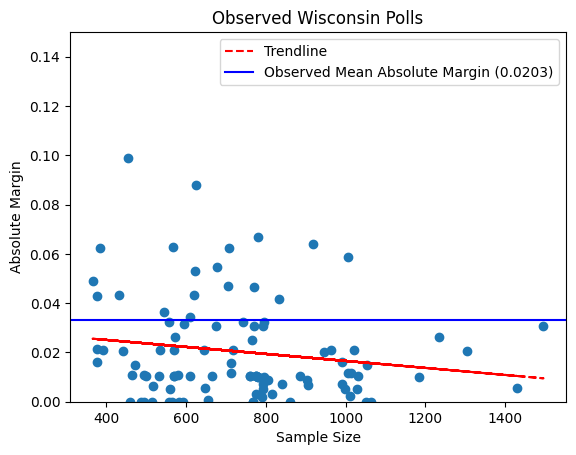

In [430]:
import matplotlib.pyplot as plt


def plot_polls(sample_sizes: list[int], absolute_margins: list[float], universe_type="Simulated"):
    plt.scatter(sample_sizes, absolute_margins)

    z = np.polyfit(sample_sizes, absolute_margins, 1)
    p = np.poly1d(z)
    plt.plot(sample_sizes,p(sample_sizes),"r--", label="Trendline")
    plt.ylim(0, 0.15)
    plt.xlabel("Sample Size")
    plt.ylabel("Absolute Margin")
    plt.title(f"{universe_type} {STATE} Polls")
    plt.axhline(mean_absolute_margin, color="blue", label=f"{universe_type} Mean Absolute Margin ({np.mean(absolute_margins):.4f})")
    plt.legend()
    plt.show()

plot_polls(data["HarrisOrTrumpTotal"], data["AbsoluteMargin"], universe_type="Observed")


This function simulates an entire universe--well, specifically it simulates several polls of a perfectly tied presidential race. The provided `sample_sizes` tells the function what sample sizes of polls to run. E.g. `[800, 1200, 1046]` (am I the only one who thinks election poll sample sizes are kind of small?)

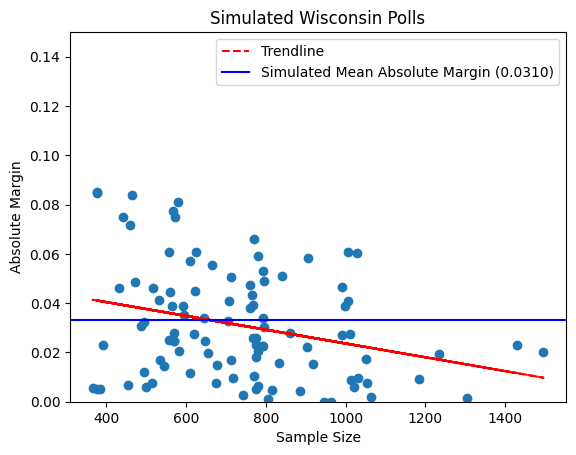

Mean absolute margin for this simulated universe: 3.10%


In [431]:
# Simulate many polls
import matplotlib.pyplot as plt

def simulate_universe(sample_sizes: list[int], print_results: bool = False, harris_share: float = 0.5) -> float:
    absolute_margins = []
    for n in sample_sizes:
        absolute_margin = simulate_poll(n, harris_share=harris_share)
        absolute_margins.append(absolute_margin)
    mean_absolute_margin = np.mean(absolute_margins)
    if print_results:
        plot_polls(sample_sizes, absolute_margins, universe_type="Simulated")
    return mean_absolute_margin

universe_mam = simulate_universe(data["HarrisOrTrumpTotal"], print_results=True)
print(f"Mean absolute margin for this simulated universe: {100 * universe_mam:.2f}%")

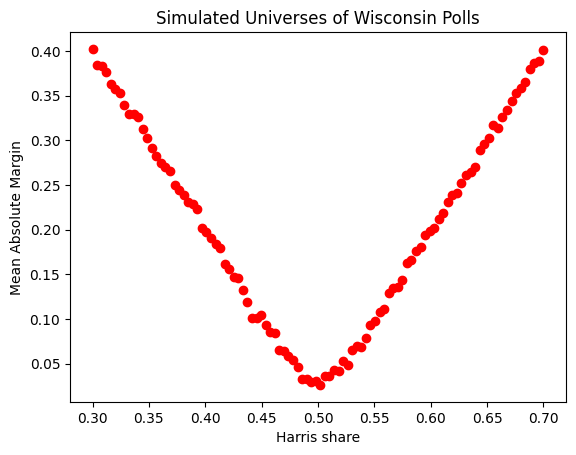

In [414]:
universe_mams = []
harris_shares = np.linspace(0.3, 0.7, 100)
for harris_share in harris_shares:
    universe_mam = simulate_universe(data["HarrisOrTrumpTotal"], harris_share=harris_share)
    universe_mams.append(universe_mam)

plt.scatter(harris_shares, universe_mams, c="red")
plt.title(f"Simulated Universes of {STATE} Polls")
plt.xlabel("Harris share")
plt.ylabel("Mean Absolute Margin")
plt.show()

Let's simulate the polls (with the same sample sizes as in the real polling data for our state) across very many alternate universes. We'll keep track of the mean absolute margin for each universe and then compare our universe's mean absolute margin to that of our multiverse.

In [404]:
NUMBER_OF_UNIVERSES = 100_000

mean_absolute_margins = []
for _ in range(NUMBER_OF_UNIVERSES):
    # Simulate the polls in this universe, then calculate the mean absolute margin:
    mean_absolute_margin = simulate_universe(data["HarrisOrTrumpTotal"])
    mean_absolute_margins.append(mean_absolute_margin)
mean_absolute_margins = np.array(mean_absolute_margins)


In [405]:
print(f"Mean absolute margin for simulated polling of {STATE} across all universes: {100 * mean_absolute_margins.mean():.2f}%")
simulated_mean_absolute_margins_above_observed = np.sum(mean_absolute_margins > np.mean(data["AbsoluteMargin"]))
share_above_observed = simulated_mean_absolute_margins_above_observed / NUMBER_OF_UNIVERSES
print(f"Across {NUMBER_OF_UNIVERSES} simulated universes, {simulated_mean_absolute_margins_above_observed} ({100 * share_above_observed:.4f}%) had a higher mean absolute margin than the one observed by pollsters in {STATE} ({100 * mean_observed_absolute_margin:.2f}%)")


Mean absolute margin for simulated polling of Wisconsin across all universes: 3.05%
Across 100000 simulated universes, 100000 (100.0000%) had a higher mean absolute margin than the one observed by pollsters in Wisconsin (2.03%)


Let's make a histogram of the observed absolute margins. We divide the $x$-axis (representing mean absolute margin) into 50 buckets, then draw a bar whose height represents how many universes' mean absolute margin falls into that bucket's range. Then, we'll draw *our* universe's mean average margin, and see whether it looks like the simulated universes' (and if it looks different, how so).

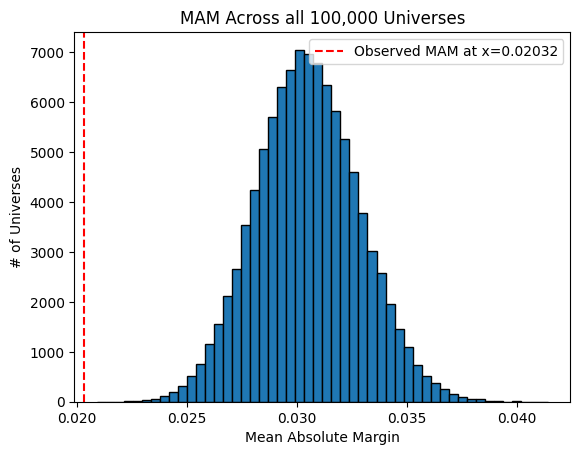

In [416]:
import matplotlib.pyplot as plt

plt.hist(mean_absolute_margins, bins=50, edgecolor='black')
plt.xlabel('Mean Absolute Margin')
plt.ylabel('# of Universes')
plt.title(f'MAM Across all {NUMBER_OF_UNIVERSES:,} Universes')

plt.axvline(x=mean_observed_absolute_margin, color='red', linestyle='--', linewidth=1.5, label=f'Observed MAM at x={mean_observed_absolute_margin:.5f}')

plt.legend()
plt.show()



In [407]:
np.percentile(mean_absolute_margins, [0.01, 1, 5, 25, 50, 75, 95, 99, 99.99])

array([0.02238461, 0.0252781 , 0.02672522, 0.02890038, 0.03045699,
       0.0320593 , 0.03439663, 0.03609936, 0.03973399])

In [408]:
mean_absolute_margins.min()

np.float64(0.02092257545507169)